In [2]:
# Importando arquivo de funcoes
import sys  
sys.path.insert(0, './funcoesTermosol.py')

import funcoesTermosol

import numpy as np

In [70]:
numero_de_nos, nos, numero_de_membros, props_membros, numero_de_cargas, forcas_nos, numero_de_apoios, restricoes = funcoesTermosol.importa('./entrada.xls')


In [71]:
numero_de_nos, nos, numero_de_membros, props_membros, numero_de_cargas, forcas_nos, numero_de_apoios, restricoes


(3,
 array([[0. , 0. , 0.3],
        [0. , 0.4, 0.4]]),
 3,
 array([[1.0e+00, 2.0e+00, 2.1e+11, 2.0e-04],
        [2.0e+00, 3.0e+00, 2.1e+11, 2.0e-04],
        [3.0e+00, 1.0e+00, 2.1e+11, 2.0e-04]]),
 2,
 array([[   0.],
        [   0.],
        [   0.],
        [   0.],
        [ 150.],
        [-100.]]),
 3,
 array([[0.],
        [2.],
        [3.]]))

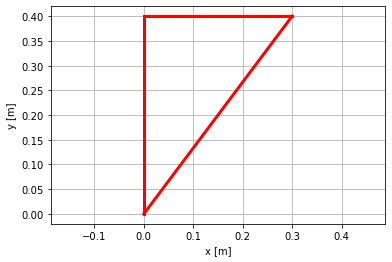

In [72]:
funcoesTermosol.plota(nos, props_membros)

In [73]:
# Funcoes suporte

def getL(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def getK(E, A, p1, p2):
    
    x1 = p1[0]
    y1 = p1[1]
    
    x2 = p2[0]
    y2 = p2[1]
    
    L = getL(x1,y1,x2,y2)
    
    s = (y2 - y1)/L
    c = (x2 - x1)/L
    
    K = np.array([
        [c**2, c*s, -c**2, -c*s],
        [c*s, s**2, -c*s, -s**2],
        [-c**2, -c*s, c**2, c*s],
        [-c*s, -s**2, c*s, s**2]
    ])
    
    return K*(E*A/L)

# GDP corresponde a 2x - 2 para X e 2x - 1 para Y.
# Ex. Nó 1. GDL: em X --> 0, em Y --> 1
# Ex. Nó 2. GDL: em X --> 2, em Y --> 3
# Ex. Nó 3. GDL: em X --> 4, em Y --> 5

def getGDLx(no):
    return 2*no - 2

def getGDLy(no):
    return 2*no - 1

# Matriz para passar do k do elemento para o global
def k_elemento_2_global(k_e, lista_indexes):
    
    for i in range(4):
        for j in range(4):
            k_global[lista_indexes[i]][lista_indexes[j]] += k_e[i][j]

In [74]:
# Loop principal
listaK = []
k_global = np.zeros((numero_de_nos*2, numero_de_nos*2))

# Loop principal
for n in range(numero_de_nos):
    
    no1 = int(props_membros[n][0])
    no2 = int(props_membros[n][1])
    
    # Gera a lista de GDP para cada elemento
    GDL_indexes = [getGDLx(no1), getGDLy(no1), getGDLx(no2), getGDLy(no2)]
    
    # Destrincha E e A do input
    E = props_membros[n][2]
    A = props_membros[n][3]
    
    # Destrincha os nós 1 e 2 de cada elemento (ajuste de index)
    p_no1 = (nos[0][no1 - 1], nos[1][no1 - 1])
    p_no2 = (nos[0][no2 - 1], nos[1][no2 - 1])
    
    # Gera a matriz K do elemento ja com o calculo de E*A/L
    K_elemento = getK(E, A, p_no1, p_no2)
    
    # Gera a matriz global
    k_elemento_2_global(K_elemento, GDL_indexes)
    
#print(k_global)

# Pega a matriz global e cortar as linhas e colunas com restrição
for i in np.flip(restricoes):
    r = int(i[0])
    k_global = np.delete(k_global, r, 0)
    k_global = np.delete(k_global, r, 1)

# Cortando restrições da matriz global de forças
for i in np.flip(restricoes):
    r = int(i[0])
    forcas_nos = np.delete(forcas_nos, r, 0)

print("Matriz global de forças")
print(forcas_nos)
print("Matriz global de rigidez")
print(k_global)

Matriz global de forças
[[   0.]
 [ 150.]
 [-100.]]
Matriz global de rigidez
[[ 1.5876e+08 -4.0320e+07 -5.3760e+07]
 [-4.0320e+07  1.7024e+08  4.0320e+07]
 [-5.3760e+07  4.0320e+07  5.3760e+07]]


In [76]:
# Solver
np.linalg.solve(k_global, forcas_nos)

array([[-9.52380952e-07],
       [ 1.60714286e-06],
       [-4.01785714e-06]])

In [77]:
# Solver proprio
n_lines_cols = numero_de_nos*2 - len(restricoes)
U = np.zeros((numero_de_nos, n_lines_cols, 1))

for l in range(0, numero_de_nos - 1):
    for i in range(0, n_lines_cols):
        soma = forcas_nos[i]
        cont = n_lines_cols-1
        
        while (cont >= 0):
            if (i != cont):
                soma -= k_global[i][cont]*U[l,cont,0]    
            cont-=1
        U[l+1,i,0] = soma/k_global[i][i]
    
    tol = (10**(-8))
        
    erro = np.amax(abs((U[l, 1:n_lines_cols-1, 0]-U[l-1, 1:n_lines_cols-1, 0])/U[l, 1:n_lines_cols-1, 0]))
    #print(erro)
        
    if (tol>=erro) and (l > 2):
        print('Convergiu!',l)
        break

/var/folders/s4/3_q0wq016y7597pk4vtjk4rm0000gn/T/ipykernel_48236/3051463499.py:18: RuntimeWarning: invalid value encountered in true_divide
  erro = np.amax(abs((U[l, 1:n_lines_cols-1, 0]-U[l-1, 1:n_lines_cols-1, 0])/U[l, 1:n_lines_cols-1, 0]))


In [78]:
U

array([[[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[ 0.00000000e+00],
        [ 8.81109023e-07],
        [-1.86011905e-06]],

       [[-4.06107862e-07],
        [ 1.32166353e-06],
        [-2.52095081e-06]]])

In [51]:
k_global = np.zeros((numero_de_nos*2, numero_de_nos*2))
k_teste = np.zeros((4,4))
k_teste[0][0] = 1
k_teste[0][1] = 2
k_teste[0][2] = 3
k_teste[0][3] = 4
k_teste[1][0] = 5
k_teste[1][1] = 6
k_teste[1][2] = 7
k_teste[1][3] = 8
k_teste[2][0] = 9
k_teste[2][1] = 10
k_teste[2][2] = 11
k_teste[2][3] = 12
k_teste[3][0] = 13
k_teste[3][1] = 14
k_teste[3][2] = 15
k_teste[3][3] = 15

lista_gdl = [0,1,4,5]

print("Global")
print(k_global)
print("K Elemento")
print(k_teste)
print("GDL list")
print(lista_gdl)

k_elemento_2_global(k_teste, lista_gdl)
k_global

Global
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
K Elemento
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 15.]]
GDL list
[0, 1, 4, 5]


array([[ 1.,  2.,  0.,  0.,  3.,  4.],
       [ 5.,  6.,  0.,  0.,  7.,  8.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 9., 10.,  0.,  0., 11., 12.],
       [13., 14.,  0.,  0., 15., 15.]])